In [90]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
from sklearn.metrics import accuracy_score
from keras import backend as K

In [91]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

### Данные:
Будем работать с датасетом [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). 

In [92]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
del y_train, y_test

In [93]:
print(np.mean(X_train).round())
print(X_train.shape)
print(X_test.shape)

73.0
(60000, 28, 28)
(10000, 28, 28)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


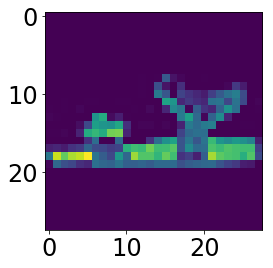

In [94]:
plt.imshow(X_train[59999].reshape([28,28]))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


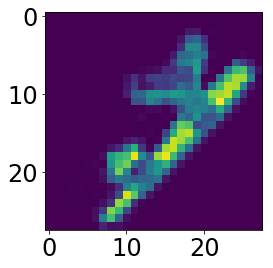

In [95]:
plt.imshow(transform.rotate(X_train[59999].reshape([28,28]), 45))

### Задание.
Ваша задача - определить, при каком минимальном угле поворота нейронная сеть фиксированной архитектуры перестает различать обычное и повертнутое изображение. Говоря формально, решаем задачу классификации, исходные изображения принадлежат классу `0`, повернутые - классу `1`. Оцените точность классификации по метрике `accuracy` и ее дисперсию в зависимости от угла поворота изображения и отобразите данную зависимость на графике.

Функция `rotate_dataset` поворачивает поданный датасет на заданный угол. Функция `reset_weights` сбрасывает параметры модели.

*Обращаем ваше внимание, что для качественной оценки данных зависимостей эксперименты для каждого размера выборки стоит повторять многократно на различных случайных подвыборках.*

In [96]:
def rotate_dataset(dataset, angle):
    return np.array(list(map(lambda x: transform.rotate(x, angle), dataset)))

In [97]:
def get_X_and_y(base_dataset, angle):
    rotated_datased = rotate_dataset(base_dataset, angle)
    whole_dataset = np.vstack((base_dataset, rotated_datased)).reshape(-1, 784)
    shuffled_indices = np.arange(len(whole_dataset))
    
    _labels = np.zeros(2*base_dataset.shape[0], dtype=bool)
    _labels[base_dataset.shape[0]:] = True
    _labels = _labels[:, None]
    
    whole_labels = np.array(np.hstack((_labels, ~_labels)), dtype=int)
    
    np.random.shuffle(shuffled_indices)    
    whole_dataset = whole_dataset[shuffled_indices]
    whole_labels = whole_labels[shuffled_indices]
    
    return whole_dataset, whole_labels


In [98]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
    return

In [99]:
# compile net itself
model = keras.models.Sequential()
model.add(keras.layers.InputLayer([784]))
model.add(keras.layers.Dense(64))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2))
model.add(keras.layers.Activation('softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [100]:
# set hyper parameters
batch_size = 128
nb_epochs = 40
N = 500  # number of samples in training dataset
nb_runs = 8  # number of times the net is trained and predictions are made for each angle

In [112]:
def count_scores(start, end, angle_step, verbose = False):
    scores=[]  # mean scores for "nb_runs" runs
    for angle in range(start, end, angle_step):
        run_score = []  # score for one run
        X_test_whole, y_test_whole = get_X_and_y(X_test, angle)
        # run several times with different samples chosen for training
        for nrun in range(nb_runs):
            # indices that are used for picking training samples out of X_train
            base_indices = np.random.choice(np.arange(X_train.shape[0]), 
                                            size=N, replace=False)
            # training dataset
            base_dataset = X_train[base_indices].reshape([-1, 28,28]) / 255
            X, y = get_X_and_y(base_dataset, angle)
            # training itself
            model.fit(X, y, batch_size=batch_size, epochs=nb_epochs, verbose=0)
            # get predictions on test data
            y_test_predicted_whole = model.predict_classes(X_test_whole)
            run_score.append(accuracy_score(y_test_whole[:, 1], y_test_predicted_whole))
            if verbose:
                print('angle={1}, run={2}/{3}'.format(N, angle, nrun+1, nb_runs))
                print("Accuracy: {0}".format(run_score[-1]))
            reset_weights(model)
        # save mean score and its standard deviation for each angle
        scores.append([angle, np.mean(run_score), np.std(run_score)])
    return scores

In [ ]:
scores = count_scores(0, 361, 30, True)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


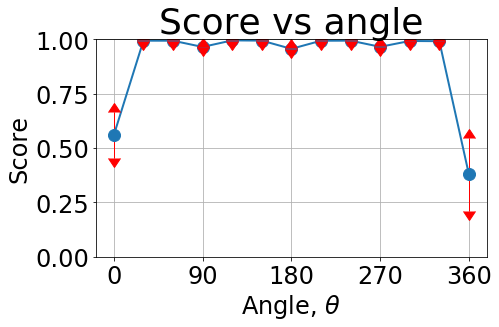

In [105]:
fig, ax1 = plt.subplots(1, 1)
ax1.set_title('Score vs angle')
ax1.set_xlabel(r'Angle, $\theta$')
ax1.set_ylabel(r'Score')

scores = np.array(scores)
plt.plot(scores[:, 0], scores[:, 1], '-o')
ax1.errorbar(scores[:, 0], scores[:, 1], yerr=scores[:, 2], fmt='none', color="red", elinewidth=1, uplims=True, lolims=True)
ax1.set_xticks(np.arange(0, 361, 90))
ax1.set_ylim(0, 1)
ax1.grid()

plt.savefig('score_v_angle_[0-360].png')
plt.show()

Как видно из графика, точность классификации почти не зависит от угла поворота, если он отличается более чем на 10 градусов от 0 или 360. Поэтому рассмотрим подробнее случаи с малыми поворотами - не более 10 градусов.

In [114]:
first_scores = count_scores(0, 11, 1, True)

angle=9, run=8/8
Accuracy: 0.97455


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


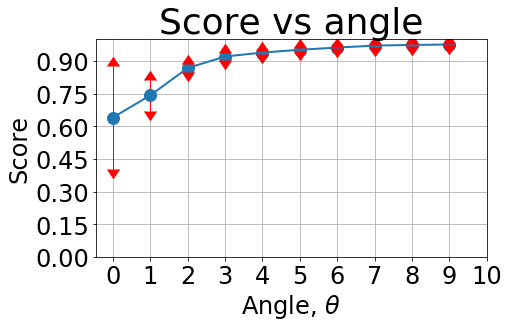

In [120]:
fig, ax2 = plt.subplots(1, 1)
ax2.set_title('Score vs angle')
ax2.set_xlabel(r'Angle, $\theta$')
ax2.set_ylabel(r'Score')

scores = np.array(first_scores)
plt.plot(scores[:, 0], scores[:, 1], '-o')
ax2.errorbar(scores[:, 0], scores[:, 1], yerr=scores[:, 2], fmt='none', color="red", elinewidth=1, uplims=True, lolims=True)
ax2.set_xticks(np.arange(0, 11, 1))
ax2.set_yticks(np.arange(0, 1, 0.15))
ax2.set_ylim(0, 1)
ax2.grid()

plt.savefig('score_v_angle_[0-30].png')
plt.show()

При отсутствии поворота (повороте 0 или 360 градусов) классифицировать не имеет смысла. При повороте на углы кратные 90 точность классификации незначительно падает на 2-3 процента.
Минимальный угол поворота при котором нейронная сеть определяет, повернуто ли изображение - 3 градуса (при меньших углах точность падает ниже 90 процентов).